# Predict Star Category Given a Yelp Review

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline
pd.options.display.mpl_style = 'default'

pd.set_option('display.max_columns', 36)

In [2]:
import nltk
import string
from nltk import word_tokenize
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

In [3]:
%%bash
# http://www2.cs.uic.edu/~liub/
# Hu, Minqing, and Bing Liu. "Mining and summarizing customer reviews." Proceedings of the tenth ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2004.
# Liu, Bing, Minqing Hu, and Junsheng Cheng. "Opinion observer: analyzing and comparing opinions on the web." Proceedings of the 14th international conference on World Wide Web. ACM, 2005.
wget --quiet --output-document=opinions.rar http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar
unrar e -o+ --silent opinions.rar > /dev/null
sed -i '/^;/d' positive-words.txt
sed -i '/^;/d' negative-words.txt

In [4]:
positive_words = set([line.strip() for line in open('positive-words.txt', 'r')])
negative_words = set([line.strip() for line in open('negative-words.txt', 'r')])
nltk_stopwords = set(stopwords.words('english'))


def remove_numbers_in_string(s):
    return s.translate(None, string.digits)

def lowercase_remove_punctuation(s):
    s = s.lower()
    s = s.translate(None, string.punctuation)
    return s
    
def remove_stopwords(s):
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in nltk_stopwords
    return ' '.join(filter(exclude_stopwords, token_list))

def stem_token_list(token_list):
    stemmer = PorterStemmer()
    return [stemmer.stem(tok.decode('utf-8')) for tok in token_list]

def restring_tokens(token_list):
    return ' '.join(token_list)

def lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring(s):
    s = remove_numbers_in_string(s)
    s = lowercase_remove_punctuation(s)
    s = remove_stopwords(s)
    token_list = nltk.word_tokenize(s)
    token_list = stem_token_list(token_list)
    return restring_tokens(token_list)

In [5]:
all_csv_filename = os.path.join("yelp_csv", 'all_p1.csv')
all_DF = pd.read_csv(all_csv_filename)
all_DF.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,business_name,neighborhoods,open,business_review_count,business_stars,state,type_x,review_date,review_id,review_stars,review_text,type_y,user_id,review_votes,average_stars,compliments,elite,fans,friends,user_name,user_review_count,type_x.1,user_votes,yelping_since,tip_date,likes,tip_text,type_y.1
0,{},6c2pWWtdQZA3w5raX6k-dg,"[Barbers, Beauty & Spas]",Homestead,"3510 Main St\nHomestead, PA 15120","{u'Tuesday': {u'close': u'17:30', u'open': u'0...",40.385508,-79.903491,Carmine's Barber Shop,[],True,3,3.5,PA,business,2014-04-23,OdwBV3AkP9sm3AxgDmuX2A,5,Great place to get a basic haircut at a fair p...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.18,{u'hot': 1},[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,47,user,"{u'funny': 8, u'useful': 46, u'cool': 10}",2011-11,2014-07-14,0,I've been told that they do open at 4 AM and i...,tip
1,"{u'Take-out': True, u'Price Range': 2, u'Outdo...",1qCuOcks5HRv67OHovAVpg,"[Pubs, Bars, American (New), Nightlife, Restau...",Homestead,"122 W 8th Ave\nHomestead\nHomestead, PA 15120",{},40.405311,-79.912595,Duke's Upper Deck Cafe,[Homestead],True,26,3.5,PA,business,2014-09-13,1tZARkIiC89Xhqd6AHLrbg,4,Food is good here. Great beer selection on tap...,review,JPPhyFE-UE453zA6K0TVgw,"{u'funny': 0, u'useful': 0, u'cool': 0}",4.21,"{u'funny': 5, u'plain': 9, u'writer': 14, u'no...","[2014, 2015]",7,"[fwsJGulnozT2U6FefsLiFw, Dsh4UCo9ny0XCrEJaF4aK...",Molly,146,user,"{u'funny': 36, u'useful': 136, u'cool': 70}",2012-06,2014-10-18,0,Half priced appetizers after 9 on week nights.,tip
2,"{u'Alcohol': u'beer_and_wine', u'Open 24 Hours...",2X5G4Ujq0s4Wfn4TC7gX0g,"[Pubs, Bars, Hot Dogs, Nightlife, Restaurants]",Pittsburgh,"1118 S Braddock Ave\nPittsburgh, PA 15218","{u'Monday': {u'close': u'23:00', u'open': u'11...",40.432022,-79.893834,D's Six Pax & Dogz,[],True,266,4.5,PA,business,2014-09-13,qs7jdIz-g-KC6BGDZCD-Fg,4,"While everyone goes here for the dogs, the piz...",review,JPPhyFE-UE453zA6K0TVgw,"{u'funny': 0, u'useful': 0, u'cool': 0}",4.21,"{u'funny': 5, u'plain': 9, u'writer': 14, u'no...","[2014, 2015]",7,"[fwsJGulnozT2U6FefsLiFw, Dsh4UCo9ny0XCrEJaF4aK...",Molly,146,user,"{u'funny': 36, u'useful': 136, u'cool': 70}",2012-06,2014-10-18,0,The special hummus is always good. Take a brea...,tip
3,{u'Good for Kids': True},cE27W9VPgO88Qxe4ol6y_g,"[Active Life, Mini Golf, Golf]",Bethel Park,"1530 Hamilton Rd\nBethel Park, PA 15234",{},40.354116,-80.014660,Cool Springs Golf Center,[],False,5,2.5,PA,business,2013-04-18,rkD7UDbQ9VM3Va6bI-eBHQ,1,Owning a driving range inside the city limits ...,review,-6rEfobYjMxpUWLNxszaxQ,"{u'funny': 0, u'useful': 1, u'cool': 0}",3.28,"{u'note': 1, u'plain': 1, u'cool': 3}",[],1,"[nEYPahVwXGD2Pjvgkm7QqQ, ukf5AhPo3dJhEWB2km-St...",Andrew,29,user,"{u'funny': 18, u'useful': 61, u'cool': 11}",2012-11,2013-04-18,0,Don't waste your time.,tip
4,"{u'Take-out': True, u'Accepts Credit Cards': T...",McikHxxEqZ2X0joaRNKlaw,"[Food, American (Traditional), Breweries, Rest...",Homestead,"171 E Bridge St\nHomestead\nHomestead, PA 15120","{u'Monday': {u'close': u'02:00', u'open': u'11...",40.409435,-79.915262,Rock Bottom,[Homestead],True,124,3.5,PA,business,2015-05-12,-wwv-TVwFri3YomBqYISpg,2,Rock Bottom: A Cautionary Yelper's Tale.\n\nYo...,review,l_szjd-ken3ma6oHDkTYXg,"{u'funny': 1, u'useful': 2, u'cool': 0}",3.72,"{u'funny': 4, u'plain': 5, u'writer': 8, u'not...",[2015],5,"[D3JoaaL9kEgnIs64SUOR2w, FP79xn8H2XXnMksRuP5l6...",Casey,107,user,"{u'funny': 49, u'useful': 202, u'cool': 141}",2011-03,2015-03-28,0,Longest wait of all time on Saturdays.,tip


In [6]:
for idx in range(5):
    print all_DF.review_text[idx]
    print

Great place to get a basic haircut at a fair price! The barbers are like local historians and seem to know something about everybody in town. You might have to wait a bit sometimes to get a haircut, seeing as there is normally only one or two guys working, but the wait normally goes by fast.

Food is good here. Great beer selection on tap. Sometimes the beer is on the pricey side. What I want from a neighborhood bar is a neighborhood special. Pinkerton is one of the best sandwiches. Good place to watch football, hockey, baseball.

While everyone goes here for the dogs, the pizza is not be ignored. Hand tossed crusts with a nice selection of specialty pizzas. 

Appetizers are good as well. Hummus is a solid choice. Not a fan of their wings. 

Beer selection is on point and if you can't find what you want on tap, head into the beer cave. I like that you can find a crazy variety and try new beers. Always busy, so be prepared to wait.

Owning a driving range inside the city limits is like 

In [7]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features_and_preprocessed_review_text = all_DF[initial_features]
%time df_with_initial_features_and_preprocessed_review_text['review_text'] = df_with_initial_features_and_preprocessed_review_text['review_text'].apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

for idx in range(5):
    print df_with_initial_features_and_preprocessed_review_text.review_text[idx]
    print

CPU times: user 34.6 s, sys: 58.5 ms, total: 34.7 s
Wall time: 34.8 s
great place get basic haircut fair price barber like local historian seem know someth everybodi town might wait bit sometim get haircut see normal one two guy work wait normal goe fast

food good great beer select tap sometim beer pricey side want neighborhood bar neighborhood special pinkerton one best sandwich good place watch footbal hockey basebal

everyon goe dog pizza ignor hand toss crust nice select specialti pizza appet good well hummu solid choic fan wing beer select point cant find want tap head beer cave like find crazi varieti tri new beer alway busi prepar wait

own drive rang insid citi limit like licens print money dont think ask much drive rang decent mat clean ball access hour hell need even less peopl advent machin dole ball place none april grass tee yet btw open season week although golf weather month mat look like carpet year old aunt iren hous worn thread bare let talk hour place equip light ye

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

In [9]:
TEST_SIZE = 0.40
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [10]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word",
                                          tokenizer = None,    
                                          preprocessor = None,
                                          ngram_range = (1, 1),
                                          binary = False,
                                          strip_accents='unicode')

binary_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,    
                                    preprocessor = None,
                                    ngram_range = (1, 1),
                                    binary = True,
                                    strip_accents='unicode')

bigram_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,
                                    preprocessor = None,
                                    ngram_range = (2, 2),
                                    strip_accents='unicode')

trigram_vectorizer = CountVectorizer(analyzer = "word",
                                     tokenizer = None,
                                     preprocessor = None,
                                     ngram_range = (3, 3),
                                     strip_accents='unicode')

bi_and_trigram_vectorizer = CountVectorizer(analyzer = "word",
                                            tokenizer = None,
                                            preprocessor = None,
                                            ngram_range = (2,3),
                                            strip_accents='unicode')

random_forest_vectorizer = CountVectorizer(analyzer = "word",
                                           tokenizer = None,
                                           preprocessor = None,
                                           ngram_range = (1,1),
                                           strip_accents = 'unicode',
                                           max_features = 1000)

## Classification

In [11]:
bow_feature_matrix_train = bag_of_words_vectorizer.fit_transform(train_X)
bow_feature_matrix_test = bag_of_words_vectorizer.transform(test_X)
bow_feature_matrix_train, bow_feature_matrix_test

(<19366x26791 sparse matrix of type '<type 'numpy.int64'>'
 	with 898976 stored elements in Compressed Sparse Row format>,
 <12912x26791 sparse matrix of type '<type 'numpy.int64'>'
 	with 594464 stored elements in Compressed Sparse Row format>)

In [12]:
multinomial_nb_classifier = MultinomialNB()
multinomial_nb_classifier.fit(bow_feature_matrix_train, train_y)
multinomial_nb_prediction = multinomial_nb_classifier.predict(bow_feature_matrix_test)

In [13]:
def make_confusion_matrix_relative(confusion_matrix):
    star_category_classes = [1, 2, 3, 4, 5]
    N = map(lambda clazz : sum(test_y == clazz), star_category_classes)
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(0, len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

# http://www.wenda.io/questions/4330313/heatmap-with-text-in-each-cell-with-matplotlibs-pyplot.html
# http://stackoverflow.com/questions/20520246/create-heatmap-using-pandas-timeseries
# http://sebastianraschka.com/Articles/heatmaps_in_r.html
# http://code.activestate.com/recipes/578175-hierarchical-clustering-heatmap-python/
def plot_confusion_matrix(confusion_matrix=[[]], title='CM', savefilename=''):
    rcm = make_confusion_matrix_relative(confusion_matrix)
    #plt.imshow(rcm, vmin=0, vmax=1, interpolation='nearest')
    c = plt.pcolor(rcm, edgecolors='k', linewidths=4, cmap='jet', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))

    def show_values(pc, fmt="%.2f", **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')

[[ 0.64576803  0.03030303  0.08568443  0.15151515  0.08672936]
 [ 0.17006803  0.20544218  0.1755102   0.35238095  0.09659864]
 [ 0.05454545  0.00564263  0.33918495  0.4645768   0.13605016]
 [ 0.01391221  0.00239866  0.03118254  0.65243464  0.30007196]
 [ 0.01686217  0.00109971  0.00623167  0.19611437  0.77969208]]


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':
/usr/lib/pymodules/pyt

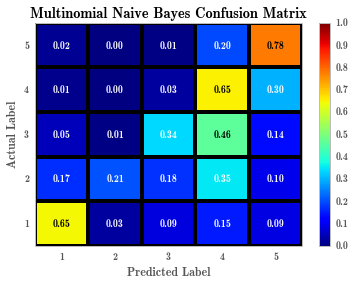

In [14]:
multinomial_confusion_matrix = confusion_matrix(test_y, multinomial_nb_prediction)
print make_confusion_matrix_relative(multinomial_confusion_matrix)
plot_confusion_matrix(multinomial_confusion_matrix, 'Multinomial Naive Bayes Confusion Matrix', savefilename='MultinomialCM.png')

In [15]:
def print_classifier_performance_metrics(name, predictions):
    target_names = ['1 star', '2 star', '3 star', '4 star', '5 star']
    
    print "MODEL: %s" % name
    print

    print 'Precision: ' + str(metrics.precision_score(test_y, predictions))
    print 'Recall: ' + str(metrics.recall_score(test_y, predictions))
    print 'F1: ' + str(metrics.f1_score(test_y, predictions))
    print 'Accuracy: ' + str(metrics.accuracy_score(test_y, predictions))

    print
    print 'Classification Report:'
    print classification_report(test_y, predictions, target_names=target_names)
    
    print
    print 'Precision variance: %f' % np.var(precision_score(test_y, predictions, average=None), ddof=len(target_names)-1)
    
    print
    print 'Recall variance: %f' % np.var(recall_score(test_y, predictions, average=None), ddof=len(target_names)-1)



In [16]:
print_classifier_performance_metrics('Multinomial Naive Bayes', multinomial_nb_prediction)

MODEL: Multinomial Naive Bayes

Precision: 0.645496807605
Recall: 0.641573729864
F1: 0.628993775739
Accuracy: 0.641573729864

Classification Report:
             precision    recall  f1-score   support

     1 star       0.63      0.65      0.64       957
     2 star       0.74      0.21      0.32       735
     3 star       0.59      0.34      0.43      1595
     4 star       0.55      0.65      0.60      4169
     5 star       0.72      0.78      0.75      5456

avg / total       0.65      0.64      0.63     12912


Precision variance: 0.026580

Recall variance: 0.232336


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Bernoulii Naive Bayes Model

In [17]:
bernoulli_feature_matrix_train = binary_vectorizer.fit_transform(train_X)
bernoulli_feature_matrix_test = binary_vectorizer.transform(test_X)
bernoulli_feature_matrix_train, bernoulli_feature_matrix_test

(<19366x26791 sparse matrix of type '<type 'numpy.int64'>'
 	with 898976 stored elements in Compressed Sparse Row format>,
 <12912x26791 sparse matrix of type '<type 'numpy.int64'>'
 	with 594464 stored elements in Compressed Sparse Row format>)

In [18]:
bernoulli_nb_classifier = BernoulliNB().fit(bernoulli_feature_matrix_train, train_y)
bernoulli_nb_prediction = bernoulli_nb_classifier.predict(bernoulli_feature_matrix_test)

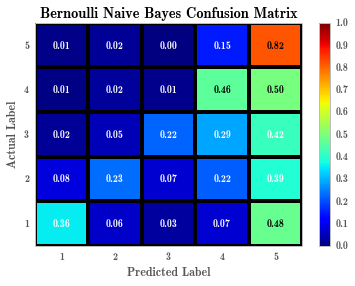

In [19]:
bernoulli_confusion_matrix = confusion_matrix(test_y, bernoulli_nb_prediction)
plot_confusion_matrix(bernoulli_confusion_matrix, 'Bernoulli Naive Bayes Confusion Matrix', savefilename='BernoulliCM.png')

In [20]:
print_classifier_performance_metrics('Bernoulli Naive Bayes', bernoulli_nb_prediction)

MODEL: Bernoulli Naive Bayes

Precision: 0.574714006178
Recall: 0.562577447336
F1: 0.537549118544
Accuracy: 0.562577447336

Classification Report:
             precision    recall  f1-score   support

     1 star       0.68      0.36      0.47       957
     2 star       0.33      0.23      0.27       735
     3 star       0.70      0.22      0.34      1595
     4 star       0.56      0.46      0.51      4169
     5 star       0.56      0.82      0.67      5456

avg / total       0.57      0.56      0.54     12912


Precision variance: 0.088154

Recall variance: 0.237759


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Bigram Naive Bayes Model

In [21]:
bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
bigram_multinomial_feature_matrix_train, bigram_multinomial_feature_matrix_test

(<19366x435809 sparse matrix of type '<type 'numpy.int64'>'
 	with 1058173 stored elements in Compressed Sparse Row format>,
 <12912x435809 sparse matrix of type '<type 'numpy.int64'>'
 	with 515296 stored elements in Compressed Sparse Row format>)

In [22]:
bigram_multinomial_nb_classifier = MultinomialNB().fit(bigram_multinomial_feature_matrix_train, train_y)
bigram_multinomial_nb_prediction = bigram_multinomial_nb_classifier.predict(bigram_multinomial_feature_matrix_test)

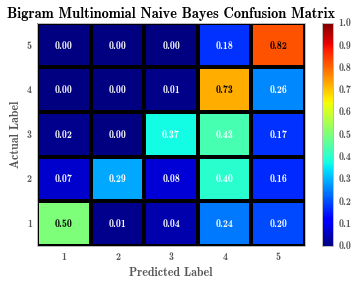

In [23]:
bigram_multinomial_confusion_matrix = confusion_matrix(test_y, bigram_multinomial_nb_prediction)
plot_confusion_matrix(bigram_multinomial_confusion_matrix, 'Bigram Multinomial Naive Bayes Confusion Matrix', savefilename='BigramMultinomialCM.png')

In [24]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes', bigram_multinomial_nb_prediction)

MODEL: Bigram Multinomial Naive Bayes

Precision: 0.70821711703
Recall: 0.681304213135
F1: 0.669161301277
Accuracy: 0.681304213135

Classification Report:
             precision    recall  f1-score   support

     1 star       0.84      0.50      0.63       957
     2 star       0.91      0.29      0.44       735
     3 star       0.80      0.37      0.51      1595
     4 star       0.58      0.73      0.65      4169
     5 star       0.73      0.82      0.77      5456

avg / total       0.71      0.68      0.67     12912


Precision variance: 0.062382

Recall variance: 0.204664


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Trigram Naive Bayes Model

In [25]:
trigram_multinomial_feature_matrix_train = trigram_vectorizer.fit_transform(train_X)
trigram_multinomial_feature_matrix_test = trigram_vectorizer.transform(test_X)
trigram_multinomial_feature_matrix_train, trigram_multinomial_feature_matrix_test

(<19366x714585 sparse matrix of type '<type 'numpy.int64'>'
 	with 1055281 stored elements in Compressed Sparse Row format>,
 <12912x714585 sparse matrix of type '<type 'numpy.int64'>'
 	with 320399 stored elements in Compressed Sparse Row format>)

In [27]:
tri_gram_multinomial_nb_classifier = MultinomialNB().fit(trigram_multinomial_feature_matrix_train, train_y)
tri_gram_multinomial_nb_prediction = tri_gram_multinomial_nb_classifier.predict(trigram_multinomial_feature_matrix_test)

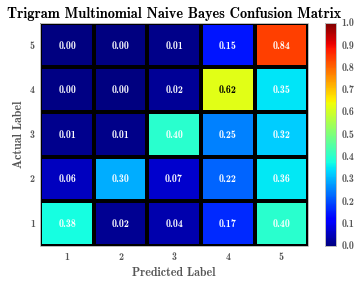

In [28]:
trigram_multinomial_confusion_matrix = confusion_matrix(test_y, tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(trigram_multinomial_confusion_matrix, 'Trigram Multinomial Naive Bayes Confusion Matrix', savefilename='TrigramMultinomialCM.png')

In [29]:
print_classifier_performance_metrics('Trigram Multinomial Naive Bayes', tri_gram_multinomial_nb_prediction)

MODEL: Trigram Multinomial Naive Bayes

Precision: 0.669858532407
Recall: 0.651486988848
F1: 0.635934869994
Accuracy: 0.651486988848

Classification Report:
             precision    recall  f1-score   support

     1 star       0.80      0.38      0.51       957
     2 star       0.82      0.30      0.44       735
     3 star       0.74      0.40      0.52      1595
     4 star       0.63      0.62      0.63      4169
     5 star       0.64      0.84      0.73      5456

avg / total       0.67      0.65      0.64     12912


Precision variance: 0.030073

Recall variance: 0.199297


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Random Forest

In [30]:
forest = RandomForestClassifier(n_estimators = 100, random_state=42)

In [31]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

In [32]:
%time forest.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest_pred = forest.predict(random_forest_feature_matrix_test.toarray())
np.save('forestpred', forest_pred)

CPU times: user 36.9 s, sys: 277 ms, total: 37.1 s
Wall time: 37.7 s


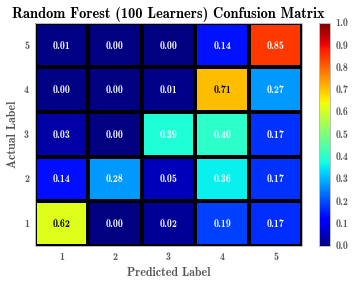

In [33]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix', savefilename='RandomForestCM.png')

In [35]:
print_classifier_performance_metrics('Random Forest (100 Learners)', forest_pred)

MODEL: Random Forest (100 Learners)

Precision: 0.71848469886
Recall: 0.696871127633
F1: 0.683825053474
Accuracy: 0.696871127633

Classification Report:
             precision    recall  f1-score   support

     1 star       0.74      0.62      0.68       957
     2 star       0.94      0.28      0.43       735
     3 star       0.84      0.39      0.53      1595
     4 star       0.61      0.71      0.66      4169
     5 star       0.73      0.85      0.78      5456

avg / total       0.72      0.70      0.68     12912


Precision variance: 0.060106

Recall variance: 0.218075


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Support Vector Machine Classifier

In [36]:
svc_feature_matrix_train = random_forest_feature_matrix_train
svc_feature_matrix_test = random_forest_feature_matrix_test

svc = SVC()

In [37]:
%time svc.fit(svc_feature_matrix_train, train_y) 

CPU times: user 2min 1s, sys: 151 ms, total: 2min 1s
Wall time: 2min 2s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
%time svc_predictions = svc.predict(svc_feature_matrix_test)
np.save('svcPred', svc_predictions)

CPU times: user 1min, sys: 7.14 ms, total: 1min
Wall time: 1min


In [40]:
if os.path.isfile('svcPred.npy'):
    svc_predictions = np.load('svcPred.npy')

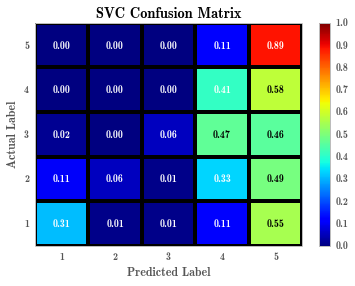

In [41]:
svc_confusion_matrix = confusion_matrix(test_y, svc_predictions)
plot_confusion_matrix(svc_confusion_matrix, 'SVC Confusion Matrix', savefilename='SVC_CM.png')

In [42]:
print_classifier_performance_metrics('SVC', svc_predictions)

MODEL: SVC

Precision: 0.586145501385
Recall: 0.542363692689
F1: 0.483024288467
Accuracy: 0.542363692689

Classification Report:
             precision    recall  f1-score   support

     1 star       0.70      0.31      0.43       957
     2 star       0.72      0.06      0.11       735
     3 star       0.81      0.06      0.10      1595
     4 star       0.50      0.41      0.45      4169
     5 star       0.55      0.89      0.68      5456

avg / total       0.59      0.54      0.48     12912


Precision variance: 0.065367

Recall variance: 0.468746


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Bigram and Trigrams

In [43]:
bi_and_trigram_multinomial_feature_matrix_train = bi_and_trigram_vectorizer.fit_transform(train_X)
bi_and_trigram_multinomial_feature_matrix_test = bi_and_trigram_vectorizer.transform(test_X)
bi_and_trigram_multinomial_feature_matrix_train, bi_and_trigram_multinomial_feature_matrix_test

(<19366x1150394 sparse matrix of type '<type 'numpy.int64'>'
 	with 2113454 stored elements in Compressed Sparse Row format>,
 <12912x1150394 sparse matrix of type '<type 'numpy.int64'>'
 	with 835695 stored elements in Compressed Sparse Row format>)

In [44]:
bi_and_tri_gram_multinomial_nb_classifier = MultinomialNB().fit(bi_and_trigram_multinomial_feature_matrix_train, train_y)
bi_and_tri_gram_multinomial_nb_prediction = bi_and_tri_gram_multinomial_nb_classifier.predict(bi_and_trigram_multinomial_feature_matrix_test)

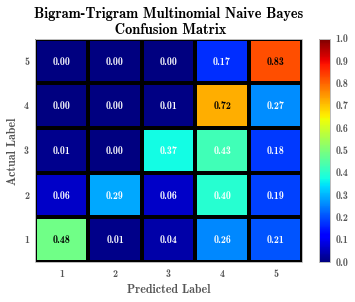

In [45]:
bi_and_tri_gram_multinomial_confusion_matrix = confusion_matrix(test_y, bi_and_tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(bi_and_tri_gram_multinomial_confusion_matrix,
                      'Bigram-Trigram Multinomial Naive Bayes \n Confusion Matrix', savefilename='BiAndTrigramMultinomialCM.png')

In [46]:
print_classifier_performance_metrics('Bi-and-Trigram Multinomial Naive Bayes', bi_and_tri_gram_multinomial_nb_prediction)

MODEL: Bi-and-Trigram Multinomial Naive Bayes

Precision: 0.711148647442
Recall: 0.681381660471
F1: 0.668650946466
Accuracy: 0.681381660471

Classification Report:
             precision    recall  f1-score   support

     1 star       0.84      0.48      0.62       957
     2 star       0.92      0.29      0.44       735
     3 star       0.83      0.37      0.52      1595
     4 star       0.58      0.72      0.65      4169
     5 star       0.72      0.83      0.77      5456

avg / total       0.71      0.68      0.67     12912


Precision variance: 0.067751

Recall variance: 0.209231


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

## Top 10 Features for each Star Category of Bag of Words Multinomial NB

In [48]:
from operator import itemgetter
N = 10
vocab = np.array([t for t, i in sorted(bag_of_words_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(multinomial_nb_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
back, order, one, like, servic, time, food, go, place, get

The top 10 most informative features for star category 2: 
servic, good, order, one, like, place, food, go, get, time

The top 10 most informative features for star category 3: 
servic, one, go, order, time, get, like, place, food, good

The top 10 most informative features for star category 4: 
alway, one, go, time, like, get, great, food, place, good

The top 10 most informative features for star category 5: 
time, like, alway, go, get, love, good, food, great, place


## Top 10 Features for each Star Category of Bigram Multinomial NB

In [49]:
N = 10
vocab = np.array([t for t, i in sorted(bigram_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(bigram_multinomial_nb_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
one star, didnt even, stay away, wait minut, never go, park lot, look like, go back, come back, custom servic

The top 10 most informative features for star category 2: 
even though, dont know, look like, feel like, everi time, tast like, last time, come back, go back, custom servic

The top 10 most informative features for star category 3: 
good food, custom servic, wife order, realli good, go back, im sure, late night, food good, come back, pretti good

The top 10 most informative features for star category 4: 
everi time, make sure, good food, food good, realli good, go back, pretti good, great place, come back, happi hour

The top 10 most informative features for star category 5: 
staff friendli, food great, one best, custom servic, great servic, highli recommend, great food, great place, yurm yurm, love place


## More feature engineering to improve classifier accuracy

In [51]:
import json
from collections import OrderedDict
 
def convert_json_dict_string_to_python_dict(json_string_dict):
    return json.loads(json_string_dict.replace('\'', '"').replace('u"', '"'))

def get_number_of_review_votes_that_are(cool_or_funny_or_useful):
    assert cool_or_funny_or_useful in ['cool', 'funny', 'useful']
    return lambda review_votes_dict : review_votes_dict[cool_or_funny_or_useful]

def get_total_review_votes(review_votes_dict):
    return review_votes_dict['cool'] + review_votes_dict['funny'] + review_votes_dict['useful']

def get_number_of_compliments_that_are(cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer):
    key = cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer
    assert cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer in [u'cool',
                                                                                                            u'cute',
                                                                                                            u'funny',
                                                                                                            u'hot',
                                                                                                            u'list',
                                                                                                            u'more',
                                                                                                            u'note',
                                                                                                            u'photos',
                                                                                                            u'plain',
                                                                                                            u'profile',
                                                                                                       u'writer']
    return lambda compliments_dict : compliments_dict[key] if key in compliments_dict else 0

def count_number_of_positive_words(document):
    return len(filter(lambda tok : tok in positive_words, document.split()))

def count_number_of_negative_words(document):
    return len(filter(lambda tok : tok in negative_words, document.split()))

def check_that_userid_does_not_appear_in_its_friendid_list(df):
    for i, x in df.iterrows():
        d = OrderedDict(x)
        assert d['business_id'] not in d['friends_id_list']

def get_average_friends_average_stars(df):
    
    def apply_func(friend_user_id_list):
        friend_ids_that_exist_in_df = set(df['user_id']).intersection(set(friend_user_id_list))
        indices_of_records_with_friend_ids = df['user_id'].isin(friend_ids_that_exist_in_df)
        userid_and_averagestars_df = df[['user_id', 'user_average_stars']]
        friends_average_stars_indexed_by_userid_df = userid_and_averagestars_df.loc[indices_of_records_with_friend_ids].groupby('user_id').mean()
        return np.mean(friends_average_stars_indexed_by_userid_df['user_average_stars'])
    
    return apply_func

## Special care on rare classes

In [54]:
TEST_SIZE = 0.40
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

In [55]:
def argmax(dictionary):
    return (max(dictionary.iteritems(), key=itemgetter(1)))[0]

class Multinomial_NB_Classifier():
    
    def train(self, class_labels, documents, class_priors=[], complement=False):       
        Classes = sorted(list(set(class_labels)))
        Vocabulary = reduce(lambda V, d : V.union(set(d.split())), documents, set())
        
        if len(class_priors) != len(Classes):
            N_documents_per_class = lambda c : sum(c == np.array(class_labels))
            N_documents = len(documents)
            class_priors = {c : N_documents_per_class(c) / float(N_documents) for c in Classes}
        
        Text_given_class = {c : documents[c == np.array(class_labels)].sum() for c in Classes}
        length_of_concatenated_documents_of_class = {c : len(Text_given_class[c].split()) for c in Classes}
        total_length_of_concatenated_documents_of_all_classes = sum([length_of_concatenated_documents_of_class[C] for C in Classes])
        
        absolute_frequency_vectorizer = CountVectorizer(analyzer = "word",
                                                        vocabulary = Vocabulary,
                                                        ngram_range = (1, 1),
                                                        binary = False)
        documentclass_termunigram_matrix = absolute_frequency_vectorizer.fit_transform(Text_given_class.values())
    
        number_of_feature_words = documentclass_termunigram_matrix.shape[1]
        feature_word_index = dict(zip(absolute_frequency_vectorizer.get_feature_names(), range(number_of_feature_words)))
        word_counts_irregardless_of_class = documentclass_termunigram_matrix.sum(axis=0)
        
        WORD_GIVEN_CLASS_CPT = {}
        COMPLEMENT_WORD_GIVEN_CLASS_CPT = {}
        K = len(Vocabulary)
        
        for class_idx, c in enumerate(Classes):
            if c not in WORD_GIVEN_CLASS_CPT:
                WORD_GIVEN_CLASS_CPT[c] = {}
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c] = {}

            for w in Vocabulary:
                T_wc = documentclass_termunigram_matrix[class_idx, feature_word_index[w]]
                WORD_GIVEN_CLASS_CPT[c][w] = float(1 + T_wc) / (K + length_of_concatenated_documents_of_class[c])
                
                C_wc = word_counts_irregardless_of_class[0, feature_word_index[w]] - T_wc
                complement_classes_wc = total_length_of_concatenated_documents_of_all_classes-length_of_concatenated_documents_of_class[c]
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c][w] = float(1 + C_wc) / (K + complement_classes_wc)
           
        self.classes = Classes
        self.vocabulary = Vocabulary
        self.class_priors = class_priors
        self.words_cpt = WORD_GIVEN_CLASS_CPT
        
        if complement:
            self.complement = True
            self.complement_cpt = COMPLEMENT_WORD_GIVEN_CLASS_CPT
        else:
            self.complement = False
            
        return self

    def predict(self, documents):
        target_labels = []
        
        for d in documents:
            score = {}
            Words_d = set(d.split())
            
            for class_idx, c in enumerate(self.classes):
                word_log_likelihoods = np.log([self.words_cpt[c][w] for w in Words_d if w in self.vocabulary])
                score[c] = np.log(self.class_priors[c])
                
                if self.complement:
                    word_in_complement_classes_log_likelihoods = np.log([self.complement_cpt[c][w] for w in Words_d if w in self.vocabulary])
                    score[c] -= sum(word_in_complement_classes_log_likelihoods)
                else:
                    score[c] += sum(word_log_likelihoods)
                    
            c_map = argmax(score)
            target_labels.append(c_map)
            
        return target_labels                            

In [56]:
%time clf = Multinomial_NB_Classifier().train(class_labels=train_y, documents=train_X)

CPU times: user 45.6 s, sys: 116 ms, total: 45.7 s
Wall time: 45.9 s


In [57]:
%time oversampling_multinomial_nb_prediction = clf.predict(test_X)

CPU times: user 1.94 s, sys: 3.91 ms, total: 1.95 s
Wall time: 1.97 s


[[ 0.71473354  0.14629049  0.06478579  0.04179728  0.03239289]
 [ 0.20272109  0.44761905  0.20272109  0.1047619   0.04217687]
 [ 0.07210031  0.10094044  0.51410658  0.22445141  0.08840125]
 [ 0.03502039  0.03190213  0.12449029  0.54737347  0.26121372]
 [ 0.03867302  0.01997801  0.0353739   0.17485337  0.7311217 ]]


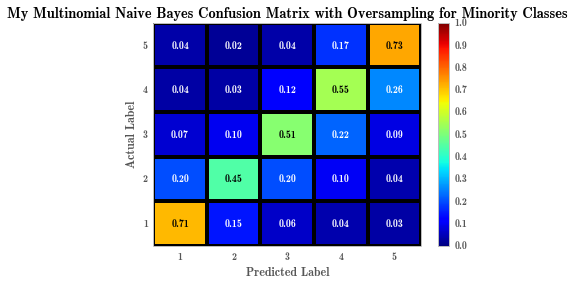

In [58]:
oversampling_multinomial_confusion_matrix = confusion_matrix(test_y, oversampling_multinomial_nb_prediction)
print make_confusion_matrix_relative(oversampling_multinomial_confusion_matrix)
plot_confusion_matrix(oversampling_multinomial_confusion_matrix,
                      'My Multinomial Naive Bayes Confusion Matrix with Oversampling for Minority Classes', savefilename='MyMultinomialOversamplingCM.png')

In [59]:
print_classifier_performance_metrics('Multinomial Naive Bayes Trained on Oversampling', oversampling_multinomial_nb_prediction)

MODEL: Multinomial Naive Bayes Trained on Oversampling

Precision: 0.636160713568
Recall: 0.627633209418
F1: 0.629802823621
Accuracy: 0.627633209418

Classification Report:
             precision    recall  f1-score   support

     1 star       0.52      0.71      0.60       957
     2 star       0.38      0.45      0.41       735
     3 star       0.47      0.51      0.49      1595
     4 star       0.61      0.55      0.58      4169
     5 star       0.76      0.73      0.74      5456

avg / total       0.64      0.63      0.63     12912


Precision variance: 0.083196

Recall variance: 0.063318


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

### Bigram multinomial naive bayes

In [63]:
oversampling_bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
oversampling_bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
oversampling_bigram_multinomial_nb_classifier = MultinomialNB().fit(oversampling_bigram_multinomial_feature_matrix_train, train_y)
oversampling_bigram_multinomial_nb_prediction = oversampling_bigram_multinomial_nb_classifier.predict(oversampling_bigram_multinomial_feature_matrix_test)

[[ 0.67293626  0.10658307  0.07419018  0.07523511  0.07105538]
 [ 0.13877551  0.40408163  0.15782313  0.2122449   0.08707483]
 [ 0.04639498  0.04576803  0.48213166  0.29467085  0.13103448]
 [ 0.01391221  0.0091149   0.05372991  0.68001919  0.24322379]
 [ 0.01173021  0.00934751  0.02162757  0.15872434  0.79857038]]


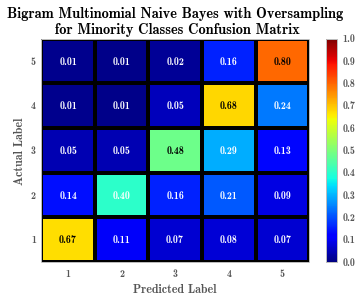

In [64]:
oversampling_bigram_multinomial_confusion_matrix = confusion_matrix(test_y, oversampling_bigram_multinomial_nb_prediction)
print make_confusion_matrix_relative(oversampling_bigram_multinomial_confusion_matrix)
plot_confusion_matrix(oversampling_bigram_multinomial_confusion_matrix,
                      'Bigram Multinomial Naive Bayes with Oversampling \n for Minority Classes Confusion Matrix', savefilename='BigramMultinomialOversamplingCM.png')

In [62]:
print_classifier_performance_metrics('Bigram Naive Bayes Trained on Oversampling', oversampling_bigram_multinomial_nb_prediction)

MODEL: Bigram Naive Bayes Trained on Oversampling

Precision: 0.684389054587
Recall: 0.689436183395
F1: 0.68540363919
Accuracy: 0.689436183395

Classification Report:
             precision    recall  f1-score   support

     1 star       0.68      0.67      0.68       957
     2 star       0.53      0.40      0.46       735
     3 star       0.59      0.48      0.53      1595
     4 star       0.64      0.68      0.66      4169
     5 star       0.76      0.80      0.78      5456

avg / total       0.68      0.69      0.69     12912


Precision variance: 0.031459

Recall variance: 0.103145


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

### Multiclass Logistic Regression Model

In [65]:
TEST_SIZE = 0.40
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [66]:
BIGRAM_RANGE = (2, 2)
v = CountVectorizer(analyzer = "word",
                    tokenizer = None,
                    preprocessor = None,
                    ngram_range = BIGRAM_RANGE,
                    strip_accents = 'unicode')

In [67]:
logistic_feature_matrix_train = v.fit_transform(train_X)
logistic_feature_matrix_test = v.transform(test_X)

logistic_feature_matrix_train, logistic_feature_matrix_test

(<19366x435809 sparse matrix of type '<type 'numpy.int64'>'
 	with 1058173 stored elements in Compressed Sparse Row format>,
 <12912x435809 sparse matrix of type '<type 'numpy.int64'>'
 	with 515296 stored elements in Compressed Sparse Row format>)

In [68]:
n_positive_words_series = df_with_initial_features_and_preprocessed_review_text.review_text.apply(count_number_of_positive_words)
n_negative_words_series = df_with_initial_features_and_preprocessed_review_text.review_text.apply(count_number_of_negative_words)
negative_to_positive_words_ratio_vector = 1000*((n_negative_words_series + 1.0)/ (n_positive_words_series+1.0)).values
negative_to_positive_words_ratio_vector = np.reshape(negative_to_positive_words_ratio_vector, (len(negative_to_positive_words_ratio_vector), 1))

In [69]:
from scipy.sparse import hstack
n_training_samples = (logistic_feature_matrix_train.shape[0])
logistic_feature_matrix_train = hstack([logistic_feature_matrix_train, negative_to_positive_words_ratio_vector[:n_training_samples]])
logistic_feature_matrix_test  = hstack([logistic_feature_matrix_test, negative_to_positive_words_ratio_vector[n_training_samples:]])

logistic_feature_matrix_train, logistic_feature_matrix_test

(<19366x435810 sparse matrix of type '<type 'numpy.float64'>'
 	with 1077539 stored elements in COOrdinate format>,
 <12912x435810 sparse matrix of type '<type 'numpy.float64'>'
 	with 528208 stored elements in COOrdinate format>)

In [70]:
logistic_clf = LogisticRegression(C=1e3)
%time logistic_clf.fit(logistic_feature_matrix_train, train_y)

CPU times: user 10.3 s, sys: 7.94 ms, total: 10.3 s
Wall time: 10.4 s


LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
%time logreg_pred = logistic_clf.predict(logistic_feature_matrix_test)

CPU times: user 17.1 ms, sys: 13 µs, total: 17.1 ms
Wall time: 17.3 ms


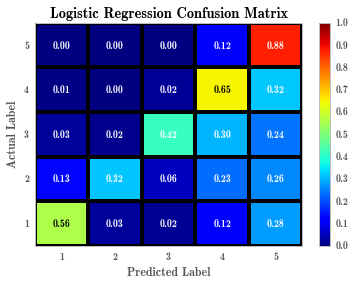

In [72]:
logreg_confusion_matrix = confusion_matrix(test_y, logreg_pred)
plot_confusion_matrix(logreg_confusion_matrix, 'Logistic Regression Confusion Matrix', savefilename='LogRegCM.png')

In [73]:
print_classifier_performance_metrics('Logistic Regression', logreg_pred)

MODEL: Logistic Regression

Precision: 0.702572218324
Recall: 0.690520446097
F1: 0.677192373455
Accuracy: 0.690520446097

Classification Report:
             precision    recall  f1-score   support

     1 star       0.75      0.56      0.64       957
     2 star       0.79      0.32      0.45       735
     3 star       0.81      0.42      0.55      1595
     4 star       0.66      0.65      0.65      4169
     5 star       0.69      0.88      0.77      5456

avg / total       0.70      0.69      0.68     12912


Precision variance: 0.017391

Recall variance: 0.186186


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

### Retraining bigram multinomial naive bayes with oversampling with different test sizes

In [74]:
TEST_SIZE = 0.20
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

In [75]:
twenty_oversampling_bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
twenty_oversampling_bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
twenty_oversampling_bigram_multinomial_nb_classifier = MultinomialNB().fit(twenty_oversampling_bigram_multinomial_feature_matrix_train, train_y)
twenty_oversampling_bigram_multinomial_nb_prediction = twenty_oversampling_bigram_multinomial_nb_classifier.predict(twenty_oversampling_bigram_multinomial_feature_matrix_test)

[[ 0.71612903  0.08817204  0.06451613  0.0688172   0.06236559]
 [ 0.14480874  0.41256831  0.16666667  0.20491803  0.07103825]
 [ 0.03875     0.03625     0.535       0.2725      0.1175    ]
 [ 0.01452671  0.00749766  0.05670103  0.69540769  0.22586692]
 [ 0.01449275  0.00743218  0.01820884  0.13786696  0.82199926]]


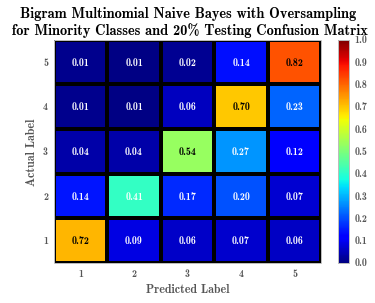

In [76]:
twenty_oversampling_bigram_multinomial_confusion_matrix = confusion_matrix(test_y, twenty_oversampling_bigram_multinomial_nb_prediction)
print make_confusion_matrix_relative(twenty_oversampling_bigram_multinomial_confusion_matrix)
plot_confusion_matrix(twenty_oversampling_bigram_multinomial_confusion_matrix,
                      'Bigram Multinomial Naive Bayes with Oversampling \n for Minority Classes and 20% Testing Confusion Matrix',
                      savefilename='TwentyBigramMultinomialOversamplingCM.png')

In [77]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes Trained on Oversampling and 20% Test Data',
                                     twenty_oversampling_bigram_multinomial_nb_prediction)

MODEL: Bigram Multinomial Naive Bayes Trained on Oversampling and 20% Test Data

Precision: 0.70885598166
Recall: 0.71375464684
F1: 0.709735076943
Accuracy: 0.71375464684

Classification Report:
             precision    recall  f1-score   support

     1 star       0.68      0.72      0.70       465
     2 star       0.59      0.41      0.48       366
     3 star       0.62      0.54      0.57       800
     4 star       0.68      0.70      0.69      2134
     5 star       0.78      0.82      0.80      2691

avg / total       0.71      0.71      0.71      6456


Precision variance: 0.021160

Recall variance: 0.104668


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

In [78]:
TEST_SIZE = 0.60
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

In [79]:
sixty_oversampling_bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
sixty_oversampling_bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
sixty_oversampling_bigram_multinomial_nb_classifier = MultinomialNB().fit(sixty_oversampling_bigram_multinomial_feature_matrix_train, train_y)
sixty_oversampling_bigram_multinomial_nb_prediction = sixty_oversampling_bigram_multinomial_nb_classifier.predict(sixty_oversampling_bigram_multinomial_feature_matrix_test)

[[ 0.64088398  0.09185083  0.08218232  0.08632597  0.09875691]
 [ 0.17302326  0.32837209  0.16465116  0.22418605  0.10976744]
 [ 0.04333333  0.04166667  0.43791667  0.31708333  0.16      ]
 [ 0.01228978  0.01180466  0.06549159  0.64020052  0.27021345]
 [ 0.01246973  0.01331719  0.02457627  0.17033898  0.77929782]]


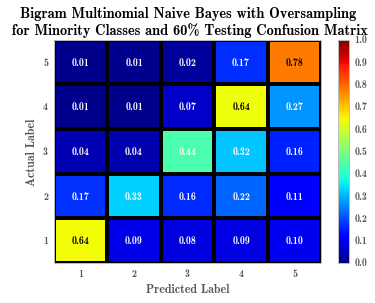

In [80]:
sixty_oversampling_bigram_multinomial_confusion_matrix = confusion_matrix(test_y, sixty_oversampling_bigram_multinomial_nb_prediction)
print make_confusion_matrix_relative(sixty_oversampling_bigram_multinomial_confusion_matrix)
plot_confusion_matrix(sixty_oversampling_bigram_multinomial_confusion_matrix,
                      'Bigram Multinomial Naive Bayes with Oversampling \n for Minority Classes and 60% Testing Confusion Matrix',
                      savefilename='SixtyBigramMultinomialOversamplingCM.png')

In [81]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes Trained on Oversampling and 60% Test Data',
                                     sixty_oversampling_bigram_multinomial_nb_prediction)

MODEL: Bigram Multinomial Naive Bayes Trained on Oversampling and 60% Test Data

Precision: 0.650106453895
Recall: 0.65720039242
F1: 0.652015069217
Accuracy: 0.65720039242

Classification Report:
             precision    recall  f1-score   support

     1 star       0.66      0.64      0.65      1448
     2 star       0.46      0.33      0.38      1075
     3 star       0.54      0.44      0.48      2400
     4 star       0.61      0.64      0.62      6184
     5 star       0.74      0.78      0.76      8260

avg / total       0.65      0.66      0.65     19367


Precision variance: 0.046319

Recall variance: 0.129479


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

In [82]:
TEST_SIZE = 0.80
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

In [83]:
eighty_oversampling_bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
eighty_oversampling_bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
eighty_oversampling_bigram_multinomial_nb_classifier = MultinomialNB().fit(eighty_oversampling_bigram_multinomial_feature_matrix_train, train_y)
eighty_oversampling_bigram_multinomial_nb_prediction = eighty_oversampling_bigram_multinomial_nb_classifier.predict(eighty_oversampling_bigram_multinomial_feature_matrix_test)

[[ 0.5601876   0.12975508  0.10526316  0.10005211  0.10474205]
 [ 0.15822785  0.30098453  0.17018284  0.21800281  0.15260197]
 [ 0.05099778  0.05701615  0.38200824  0.31738993  0.1925879 ]
 [ 0.01401643  0.02114548  0.07431126  0.5698405   0.32068632]
 [ 0.01565753  0.01728663  0.030591    0.18535614  0.7511087 ]]


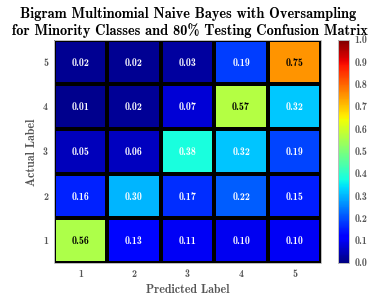

In [84]:
eighty_oversampling_bigram_multinomial_confusion_matrix = confusion_matrix(test_y, eighty_oversampling_bigram_multinomial_nb_prediction)
print make_confusion_matrix_relative(eighty_oversampling_bigram_multinomial_confusion_matrix)
plot_confusion_matrix(eighty_oversampling_bigram_multinomial_confusion_matrix,
                      'Bigram Multinomial Naive Bayes with Oversampling \n for Minority Classes and 80% Testing Confusion Matrix',
                      savefilename='EightyBigramMultinomialOversamplingCM.png')

In [85]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes Trained on Oversampling and 80% Test Data',
                                     eighty_oversampling_bigram_multinomial_nb_prediction)

MODEL: Bigram Multinomial Naive Bayes Trained on Oversampling and 80% Test Data

Precision: 0.600797500915
Recall: 0.608914533555
F1: 0.603680104003
Accuracy: 0.608914533555

Classification Report:
             precision    recall  f1-score   support

     1 star       0.61      0.56      0.59      1919
     2 star       0.35      0.30      0.32      1422
     3 star       0.46      0.38      0.42      3157
     4 star       0.57      0.57      0.57      8276
     5 star       0.69      0.75      0.72     11049

avg / total       0.60      0.61      0.60     25823


Precision variance: 0.071768

Recall variance: 0.124263


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

### Random forest on %20 test data 

In [86]:
TEST_SIZE = 0.20
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [87]:
forest = RandomForestClassifier(n_estimators = 100)

In [88]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

In [89]:
%time forest.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest_pred = forest.predict(random_forest_feature_matrix_test.toarray())

CPU times: user 57 s, sys: 245 ms, total: 57.2 s
Wall time: 58.6 s


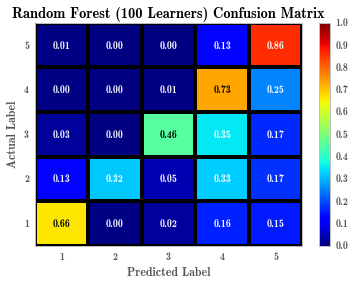

In [90]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix',
                      savefilename='TwentyRandomForestCM.png')

In [91]:
print_classifier_performance_metrics('Random Forest (100 Learners)', forest_pred)

MODEL: Random Forest (100 Learners)

Precision: 0.743398866451
Recall: 0.724132589839
F1: 0.713960094269
Accuracy: 0.724132589839

Classification Report:
             precision    recall  f1-score   support

     1 star       0.77      0.66      0.71       465
     2 star       0.94      0.32      0.48       366
     3 star       0.88      0.46      0.60       800
     4 star       0.66      0.73      0.69      2134
     5 star       0.74      0.86      0.80      2691

avg / total       0.74      0.72      0.71      6456


Precision variance: 0.051748

Recall variance: 0.188207


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

In [92]:
TEST_SIZE = 0.20
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

In [93]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

In [94]:
%time forest.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest_pred = forest.predict(random_forest_feature_matrix_test.toarray())

CPU times: user 1min 41s, sys: 269 ms, total: 1min 41s
Wall time: 1min 42s


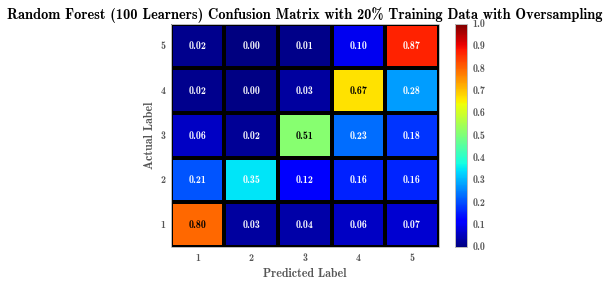

In [95]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix with 20% Training Data with Oversampling',
                      savefilename='TwentyOversamplingRandomForestCM.png')

In [96]:
print_classifier_performance_metrics('Random Forest (100 Learners) with 20% Training Data', forest_pred)

MODEL: Random Forest (100 Learners) with 20% Training Data

Precision: 0.727159700095
Recall: 0.726765799257
F1: 0.717626583134
Accuracy: 0.726765799257

Classification Report:
             precision    recall  f1-score   support

     1 star       0.65      0.80      0.72       465
     2 star       0.73      0.35      0.47       366
     3 star       0.73      0.51      0.60       800
     4 star       0.73      0.67      0.70      2134
     5 star       0.74      0.87      0.80      2691

avg / total       0.73      0.73      0.72      6456


Precision variance: 0.004989

Recall variance: 0.181490


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl